In [2]:
import influxdb_client as influxdb
import json
import pandas as pd
from influxdb_client.client.write_api import ASYNCHRONOUS
from influxdb_client.client.bucket_api import BucketsApi
import matplotlib.pyplot as plt

with open("config.json", "r") as f:
    config = json.load(f)
    token = config["token"]
    org = config["org"]
    bucket_name = config["bucket"]
    url = config["url"]

# Create a client
client = influxdb.InfluxDBClient(url=url, token=token, org=org)

# create a bucket if it doesn't exist else delete all data in the bucket
bucket_api = BucketsApi(client)
bucket = bucket_api.find_bucket_by_name(bucket_name)

if not bucket:
	bucket_api.create_bucket(bucket_name=bucket_name, org=org)


HUMIDITY_WARNING_THRESHOLD = 90
HUMIDITY_ALERT_THRESHOLD = 98
TEMPERATURE_ALERT_THRESHOLD = 45

In [26]:
def get_season(timestamp):
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    if month == 12 and day >= 21 or month == 1 or month == 2 or month == 3 and day < 21:
        return "Winter"
    elif month == 3 and day >= 21 or month == 4 or month == 5 or month == 6 and day < 21:
        return "Spring"
    elif month == 6 and day >= 21 or month == 7 or month == 8 or month == 9 and day < 21:
        return "Summer"
    elif month == 9 and day >= 21 or month == 10 or month == 11 or month == 12 and day < 21:
        return "Autumn"
    

In [27]:
def create_point(humidity, temperature, pressure, timestamp, city):
    # parse input
    humidity = float(humidity)
    temperature = float(temperature) - 273.15
    pressure = float(pressure)
    # get the season from the timestamp
    season = get_season(timestamp=timestamp)

    # create a point
    point = influxdb.Point("weather")

    if humidity >= 0 and humidity <= 100:
        point.field("humidity", humidity)
    if temperature >= -50 and temperature <= 50:
        point.field("temperature", temperature)

    if humidity > HUMIDITY_ALERT_THRESHOLD:
        print(f"ALERT: Very high humidity in {city} at {timestamp}")
    elif humidity > HUMIDITY_WARNING_THRESHOLD:
        print(f"WARNING: High humidity in {city} at {timestamp}")
    if temperature > TEMPERATURE_ALERT_THRESHOLD:
        print(f"ALERT: High temperature in {city} at {timestamp}")

    point.field("pressure", pressure)
    point.tag("season", season)
    point.tag("city", city)
    point.time(timestamp)

    return point

In [5]:
def write():
    # load csv into pandas dataframe
    cities = pd.read_csv("archive/city_attributes.csv")
    humidity = pd.read_csv("archive/humidity.csv")
    pressure = pd.read_csv("archive/pressure.csv")
    temperature = pd.read_csv("archive/temperature.csv")

    write_api = client.write_api(write_options=ASYNCHRONOUS)
    
    print("Start processing data...")
    points: list[influxdb.Point] = []
    for j in range(len(cities)):
        for i in range(len(humidity)):
            time_ = humidity["datetime"][i]
            humidity_ = humidity[cities["City"][j]][i]
            pressure_ = pressure[cities["City"][j]][i]
            temperature_ = temperature[cities["City"][j]][i]

            point = create_point(humidity_, temperature_, pressure_, time_, cities["City"][j])
            points.append(point)
    
    print("Writing data to InfluxDB...")
    
    tmp = []
    for j in range(len(points)):
        if j % 100000 == 0:
            write_api.write(bucket_name, org, tmp)
            print(f"Writing point {j} of {len(points)}")
            tmp = []
        tmp.append(points[j])
    
write()

Start processing data...
Writing data to InfluxDB...
Writing point 0 of 1629108
Writing point 100000 of 1629108
Writing point 200000 of 1629108
Writing point 300000 of 1629108
Writing point 400000 of 1629108
Writing point 500000 of 1629108
Writing point 600000 of 1629108
Writing point 700000 of 1629108
Writing point 800000 of 1629108
Writing point 900000 of 1629108
Writing point 1000000 of 1629108
Writing point 1100000 of 1629108
Writing point 1200000 of 1629108
Writing point 1300000 of 1629108
Writing point 1400000 of 1629108
Writing point 1500000 of 1629108
Writing point 1600000 of 1629108


Querying data from InfluxDB...


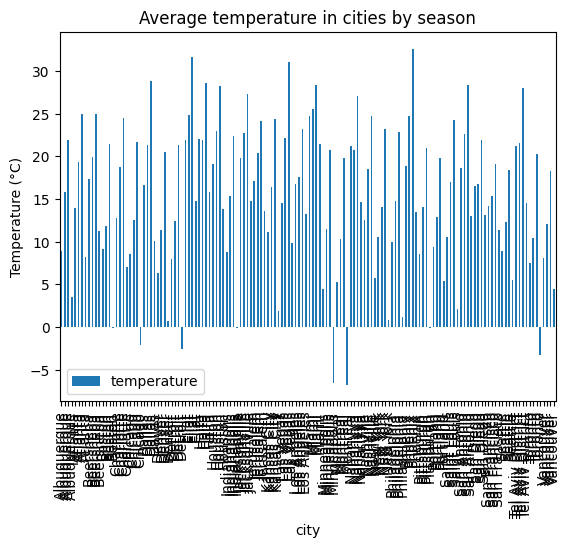

In [30]:
query = f'''
from(bucket: "{bucket_name}")
  |> range(start: -15y)
  |> filter(fn: (r) => r._measurement == "weather")
  |> filter(fn: (r) => r._field == "temperature")
  |> mean()
'''

query_api = client.query_api()
result = query_api.query(org=org, query=query)

print("Querying data from InfluxDB...")

data = []
for table in result:
    for record in table.records:
        tmp = {
            "city": record.values['city'],
			"season": record.values['season'],
			"temperature": record.values['_value']
		}
        data.append(tmp)
        
# use matplotlib to plot the data into a bar chart and put the labels vertically
df = pd.DataFrame(data)
df.plot.bar(x='city', y='temperature', rot=0)
plt.xticks(rotation=90)
plt.ylabel("Temperature (°C)")
plt.title("Average temperature in cities by season")
plt.show()
